# **VitaWeave AI**
A Content-Based Health & Lifestyle Recommendation Engine

### Selected Project Track
Health & Lifestyle Artificial Intelligence

VitaWeave AI combines “Vita” (life and vitality) with “Weave”, representing the intelligent integration of multiple health and lifestyle factors.
It reflects a system that holistically connects diverse health signals to deliver personalized lifestyle recommendations.

### Objective of the Project
In this project, I am building a content-based health and lifestyle recommendation
system that analyzes a user’s basic health and lifestyle parameters and produces
a meaningful **Lifestyle Score** along with personalized recommendations.

### Problem Statement
Today, many people track health-related data such as BMI, workouts, water intake,
and meals. However, this data is usually shown as numbers and charts, without clear
guidance on what actions to take.

The goal of VitaWeave AI is to convert raw health data into **simple, explainable,
and personalized recommendations** that users can actually follow.

### Why This Project Is Important
This project has real-world relevance for fitness apps, wellness platforms, and
preventive healthcare systems. It also provides a strong base for future integration
with wearable devices such as Fitbit, Apple Watch, and Android Health.

**Current Scope:**
- Predict a Lifestyle Score using user health & lifestyle data
- Generate personalized recommendations for:
  - Workout
  - Nutrition
  - Recovery
  - Health education


In [37]:
# system Handling
import os
import warnings
import joblib # => model deployment

# Data Handling
import numpy as np # linear algebra
import pandas as pd # data processing

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Data Understanding & Preparation

### Dataset Used
The dataset used in this project is `Final_data.csv`. It contains structured
health and lifestyle information at the individual user level.

Final_data.csv -> https://www.kaggle.com/datasets/jockeroika/life-style-data/versions/6/data

### What the Dataset Contains
- Age and Gender
- BMI and Body Fat Percentage
- Workout frequency per week
- Daily water intake
- Daily meal frequency

### Data Preparation Steps
To ensure data quality and model reliability, I:
- Loaded the dataset using Pandas
- Selected only the relevant health features
- Removed rows with missing or incomplete values
- Ensured that all inputs fall within realistic human health ranges

### Feature Engineering
Since the dataset does not directly contain a target label, I designed a
rule-based **Lifestyle Score (0–10)** that reflects overall lifestyle quality.
This score is later learned by the machine learning model.




## Dataset Loading
- The dataset contains user health and lifestyle attributes.
- In future versions, this dataset can be augmented with wearable sensor data.


In [38]:
df = pd.read_csv("/content/drive/MyDrive/Final_data.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (20000, 54)


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,...,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,...,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,...,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,...,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,8.987921e+19,High
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,...,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176,5.264685e+19,Low


High-Level System Flow

---

User Health Profile -> Feature Preprocessing ->
Machine Learning Model ->Lifestyle Score ->
Personalized Recommendations

## Data Cleaning & Feature Selection
- Only relevant health and lifestyle features are retained.
- Missing values are removed to ensure training stability.

In [39]:
# Selecting only relevant columns for content-based modeling
required_columns = [
    'Age',
    'Gender',
    'BMI',
    'Fat_Percentage',
    'Workout_Frequency (days/week)',
    'Physical exercise',
    'Water_Intake (liters)',
    'Daily meals frequency'
]

# Drop rows with missing values to maintain data integrity
df = df[required_columns].dropna()
df.head()

,Age,Gender,BMI,Fat_Percentage,Workout_Frequency (days/week),Physical exercise,Water_Intake (liters),Daily meals frequency
0,34.91,Male,24.87,26.800377,3.99,0.01,1.50,2.99
1,23.37,Female,23.48,27.655021,4.00,0.97,1.90,3.01
2,33.20,Female,21.15,24.320821,2.99,-0.02,1.88,1.99
3,38.69,Female,32.45,32.813572,3.99,0.04,2.50,3.00
4,45.09,Male,14.83,17.307319,4.00,3.00,2.91,3.00


## User Input Validation
- Ensures realistic human values.
- The same logic is reused during real-time inference.

In [40]:
def validate_user(user):
    errors = []

    if not (10 <= user['Age'] <= 90):
        errors.append("Age must be between 10 and 90")

    if not (0 < user['BMI'] <= 60):
        errors.append("Invalid BMI")

    if not (0 <= user['Fat_Percentage'] <= 60):
        errors.append("Invalid fat percentage")

    if not (0 <= user['Workout_Frequency (days/week)'] <= 7):
        errors.append("Workout frequency must be 0–7")

    if not (0.5 <= user['Water_Intake (liters)'] <= 6):
        errors.append("Unrealistic water intake")

    if not (1 <= user['Daily meals frequency'] <= 7):
        errors.append("Meal frequency must be 1–7")

    return errors

## Lifestyle Score Engineering
- A rule-based score (0–10) representing overall lifestyle quality.
- This acts as the learning target for the ML model.


In [41]:
def compute_lifestyle_score(row):
    score = 0

    # BMI
    if 18.5 <= row['BMI'] <= 24.9:
        score += 2
    elif 25 <= row['BMI'] <= 29.9:
        score += 1
    else:
        score += 0.5

    # Fat percentage
    score += 2 if row['Fat_Percentage'] <= 22 else 1

    # Workout frequency
    score += min(row['Workout_Frequency (days/week)'] / 5 * 2, 2)

    # Hydration
    score += min(row['Water_Intake (liters)'] / 2.5 * 2, 2)

    # Meals
    score += 2 if 3 <= row['Daily meals frequency'] <= 5 else 1

    return round(min(score, 10), 2)

df['Lifestyle_Score'] = df.apply(compute_lifestyle_score, axis=1)
df.head()

,Age,Gender,BMI,Fat_Percentage,Workout_Frequency (days/week),Physical exercise,Water_Intake (liters),Daily meals frequency,Lifestyle_Score
0,34.91,Male,24.87,26.800377,3.99,0.01,1.50,2.99,6.80
1,23.37,Female,23.48,27.655021,4.00,0.97,1.90,3.01,8.12
2,33.20,Female,21.15,24.320821,2.99,-0.02,1.88,1.99,6.70
3,38.69,Female,32.45,32.813572,3.99,0.04,2.50,3.00,7.10
4,45.09,Male,14.83,17.307319,4.00,3.00,2.91,3.00,8.10


## Feature Preprocessing Pipeline
- Numerical features → Standard Scaling
- Categorical features → One-Hot Encoding


In [42]:
cat_features = ['Gender', 'Physical exercise']
num_features = [
    'Age',
    'BMI',
    'Fat_Percentage',
    'Workout_Frequency (days/week)',
    'Water_Intake (liters)',
    'Daily meals frequency'
]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

## Model Selection & Training

Random Forest is chosen for:
- Non-linear learning
- Robustness to noisy human data
- Strong performance without heavy tuning


In [31]:
model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        random_state=42
    ))
])

features = num_features + cat_features
X = df[features]
y = df['Lifestyle_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'BMI',
                                                   'Fat_Percentage',
                                                   'Workout_Frequency '
                                                   '(days/week)',
                                                   'Water_Intake (liters)',
                                                   'Daily meals frequency']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Physical exercise'])])),
                ('rf',
                 RandomForestRegressor(max_depth=8, n_estimators=200,
                                       random_state=42))])

## Evaluation & Analysis

### How I Evaluated the Model
I evaluated the model using MAE, RMSE, and R² to understand how accurately the
predicted Lifestyle Score matches the expected values on unseen data.

### Key Observations
The Random Forest model performs consistently and handles non-linear relationships
between lifestyle features effectively.

### Dataset Limitations
- The dataset is static and represents a single point in time
- Long-term health trends are not captured
- Wearable-based metrics such as heart rate and sleep are not included yet

### Responsible Use of AI
This system is designed for lifestyle guidance only.
It should not be used as a medical diagnosis or treatment tool.


In [32]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance")
print("------------------")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R2  :", round(r2, 4))


Model Performance
------------------
MAE : 0.0211
RMSE: 0.0418
R2  : 0.9983


## Inference & Recommendation Engine
- ML predicts lifestyle score.
- Rule-based logic converts score into actionable content.


In [33]:
def predict_lifestyle_score(user):
    errors = validate_user(user)
    if errors:
        return {"errors": errors}

    user_df = pd.DataFrame([user])
    score = model.predict(user_df)[0]
    return round(float(np.clip(score, 0, 10)), 2)


In [34]:
def health_lifestyle_recommendation(user, score):
    content = {
        "workout": [],
        "nutrition": [],
        "recovery": [],
        "education": []
    }

    bmi = user['BMI']
    fat = user['Fat_Percentage']
    freq = user['Workout_Frequency (days/week)']
    water = user['Water_Intake (liters)']
    meals = user['Daily meals frequency']
    exercise = str(user['Physical exercise']).lower()

    # WORKOUT
    if score < 4:
        content["workout"] += [
            "Beginner walking plan (20–30 min/day)",
            "Low-impact bodyweight exercises",
            "Joint mobility routine"
        ]
    elif score < 7:
        content["workout"] += [
            "Strength + cardio hybrid training",
            "Progressive overload basics",
            "3–4 day weekly split"
        ]
    else:
        content["workout"] += [
            "Performance optimization training",
            "Advanced cardio zone training",
            "Muscle periodization strategy"
        ]

    if bmi >= 25 or fat > 25:
        content["workout"].append("Fat-loss focused Zone-2 cardio")

    if freq >= 6:
        content["workout"].append("Deload week planning")

    # NUTRITION
    if meals < 3:
        content["nutrition"].append("Increase to 3–5 balanced meals daily")

    if bmi < 18.5:
        content["nutrition"] += [
            "Calorie surplus planning",
            "Protein-dense foods"
        ]
    elif bmi >= 25:
        content["nutrition"] += [
            "Calorie-controlled diet",
            "Portion control strategies"
        ]
    else:
        content["nutrition"].append("Macro-balanced diet")

    if water < 2:
        content["nutrition"].append("Hydration & electrolyte optimization")

    # RECOVERY
    if freq >= 5:
        content["recovery"] += [
            "Active recovery sessions",
            "DOMS management techniques"
        ]

    if score < 6:
        content["recovery"].append("Sleep optimization (7–9 hours)")

    if "cardio" in exercise:
        content["recovery"].append("Heart-rate recovery monitoring")

    # EDUCATION
    if score < 5:
        content["education"] += [
            "Building long-term fitness habits",
            "Consistency over intensity"
        ]
    elif score < 8:
        content["education"] += [
            "Metabolic health fundamentals",
            "Stress–sleep–exercise balance"
        ]
    else:
        content["education"] += [
            "Injury prevention strategies",
            "Longevity-focused fitness"
        ]

    content["education"].append("Tracking progress without obsession")

    return content

## Health Radar Visualization
- Visual summary of user's health dimensions.

Predicted Lifestyle Score:  7.21

Recommendations:

WORKOUT:
* Performance optimization training
* Advanced cardio zone training
* Muscle periodization strategy
* Fat-loss focused Zone-2 cardio

NUTRITION:
* Increase to 3–5 balanced meals daily
* Macro-balanced diet
* Hydration & electrolyte optimization

RECOVERY:
* Active recovery sessions
* DOMS management techniques
* Heart-rate recovery monitoring

EDUCATION:
* Metabolic health fundamentals
* Stress–sleep–exercise balance
* Tracking progress without obsession




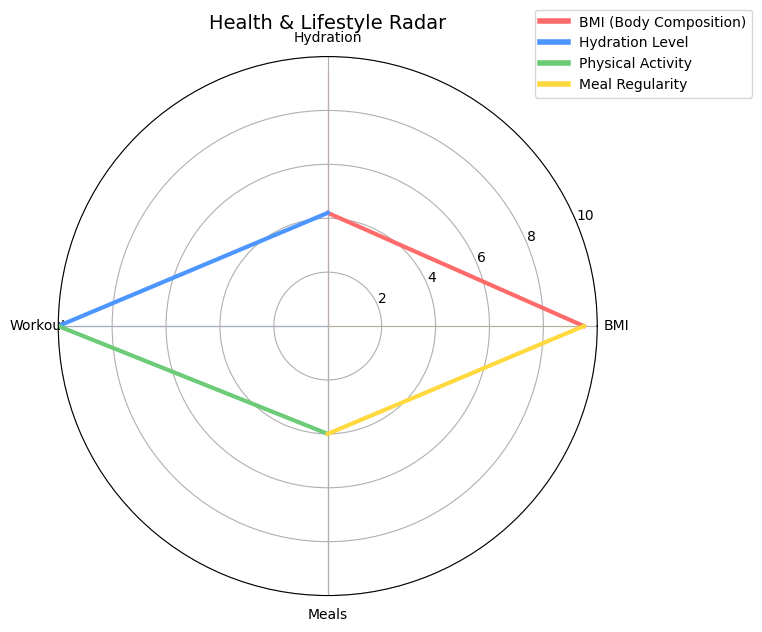

In [35]:
def plot_health_radar(user):
    labels = ['BMI', 'Hydration', 'Workout', 'Meals']

    values = [
        max(0, 10 - abs(user['BMI'] - 22)),                    # BMI score
        min(user['Water_Intake (liters)'] * 3, 10),            # Hydration
        min(user['Workout_Frequency (days/week)'] * 2, 10),    # Workout
        min(user['Daily meals frequency'] * 2, 10)             # Meals
    ]

    values = np.clip(values, 0, 10)
    values = np.append(values, values[0]) # Fix: Use np.append for numpy array

    angles = np.linspace(0, 2*np.pi, len(labels)+1)

    colors = ['#FF6B6B', '#4D96FF', '#6BCB77', '#FFD93D']

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)

    # Plot each segment separately with color
    for i in range(len(labels)):
        ax.plot(
            [angles[i], angles[i+1]],
            [values[i], values[i+1]],
            color=colors[i],
            linewidth=3
        )
        ax.fill(
            [angles[i], angles[i+1], angles[i+1]],
            [0, values[i], values[i+1]],
            color=colors[i],
            alpha=0.25
        )

    ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
    ax.set_ylim(0, 10)
    ax.set_title("Health & Lifestyle Radar", fontsize=14, pad=20)

    # Legend
    legend_labels = [
        "BMI (Body Composition)",
        "Hydration Level",
        "Physical Activity",
        "Meal Regularity"
    ]
    for c, l in zip(colors, legend_labels):
        ax.plot([], [], color=c, linewidth=4, label=l)

    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

user = {
    'Age': 30,
    'Gender': 'Male',
    'BMI': 22.5,
    'Fat_Percentage': 30,
    'Workout_Frequency (days/week)': 5,
    'Physical exercise': 'Cardio',
    'Water_Intake (liters)': 1.4,
    'Daily meals frequency': 2
}

score = predict_lifestyle_score(user)
content = health_lifestyle_recommendation(user, score)

print("Predicted Lifestyle Score: ", score)
print("\nRecommendations:")
for section, items in content.items():
    print(f"\n{section.upper()}:")
    for item in items:
        print("*", item)
print("\n")
plot_health_radar(user)


In [36]:
# Save model for deployment
joblib.dump(model, 'health_lifestyle_recommender.pkl')
print("\n✅ Model saved as health_lifestyle_recommender.pkl")


✅ Model saved as health_lifestyle_recommender.pkl


## Wearable Integration – Future Scope

In the future, VitaWeave AI can be extended to integrate real-time data from wearable
devices. This will allow the system to move from static recommendations to adaptive
and continuously improving health guidance.

### Wearable Future-Scope Architecture

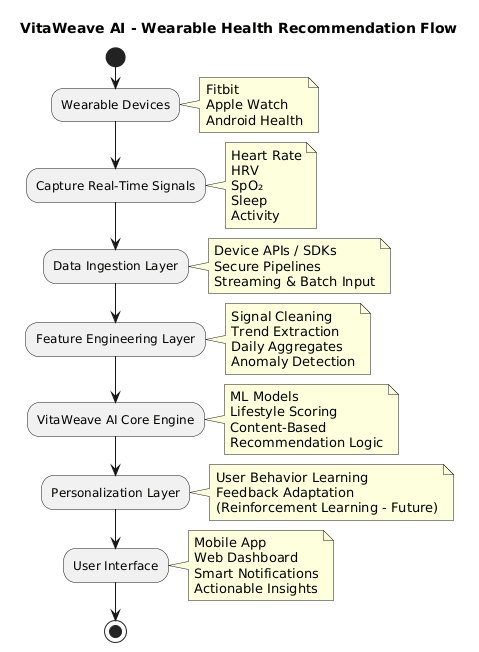


### Benefits of Wearable Integration
- Enables real-time feedback instead of static advice
- Tracks long-term health trends
- Allows personalized recommendations to evolve with user behavior
- Improves accuracy using continuous physiological signals
